In [1]:
#Import necessary libraries
!pip install scikit-learn

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load the dataset
df = pd.read_csv('/content/energy_iter13c.csv')
df2=df.copy()
df3=df.copy()

In [4]:
df.head(2)

,Date,Demand(MW),Generation(MW),Temp(C),Year,Month,Season,IsHoliday,DemandGenGap(MW)
0,2024-12-31,-0.855166,0.537407,-2.304651,2024,12,0,0,1.588629
1,2024-12-30,-0.754021,0.884273,-1.472501,2024,12,0,0,1.794999


In [5]:
#Extract day from date
df['Date']=pd.to_datetime(df['Date'])
df['Day']=df['Date'].dt.day

# **SVM**

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score


In [7]:
#Scaling(Day,Year,Month)features just for Linear regression model
#Use Standard Scaler

features=["Day","Month","Year"]
scaler=StandardScaler()
df[features]=scaler.fit_transform(df[features])

print("scaling done")

scaling done


In [10]:
#Separate features and target for train-test split
#Drop the Date features beause we cant use date as datestamp format in Random Forest model
#Our Target is Energy Demand

X = df.drop(columns=['Demand(MW)','Date','DemandGenGap(MW)'])
y = df['Demand(MW)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Use different hyperparameter combinations
param_dist = {

    'kernel': [ 'rbf','linear','poly'],
    'degree': [ 3,5,7,10],
    'coef0': [-1, 0,1],
    #'gamma':['scale','auto']

}


svm_regressor = SVR()

random_search = RandomizedSearchCV(svm_regressor, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

#Find the best hyperparameters combinations
best_params = random_search.best_params_
print("Best Hyperparameters:",  best_params)


# Train the model with the best hyperparameters
best_svr=SVR(**best_params)
best_svr.fit(X_train, y_train)



#prediction
y_pred = best_svr.predict(X_test)


#evaluation parameter
r2=r2_score(y_test,y_pred)
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)

#Show result with different evaluation parameter
print(f"R Squared:{r2:.5f}")
print(f'Mean absolute error:{mae:.5f}')
print(f'Mean Squared error:{mse:.5f}')
print(f'Root Mean Squared error:{rmse:.5f}')


Best Hyperparameters: {'kernel': 'rbf', 'degree': 7, 'coef0': 1}
R Squared:0.89718
Mean absolute error:0.21092
Mean Squared error:0.09836
Root Mean Squared error:0.31363


# **Gradient Boosting Model**

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

In [12]:
#Separate features and target for train-test split
#Drop the Date features beause we cant use date as datestamp format in Random Forest model
#Our Target is Energy Demand

X = df2.drop(columns=['Demand(MW)','Date','DemandGenGap(MW)'])
y = df2['Demand(MW)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


gb_model = GradientBoostingRegressor()

param_dist = {
    'n_estimators': [10,30],
    'learning_rate':[0.01,0.03,0.1],
    'max_depth': [1,5],
    'subsample': [0.7, 1.0],
    'min_samples_split': [2, 5, 10],
}


random_search = RandomizedSearchCV(gb_model, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42,n_jobs=-1)
random_search.fit(X_train, y_train)

#find the best model
best_gb_model = random_search.best_estimator_

#prediction
y_pred = best_gb_model.predict(X_test)


#evaluation parameter
r2=r2_score(y_test,y_pred)
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)

#Show result with different evaluation parameter
print(f"R Squared:{r2:.5f}")
print(f'Mean absolute error:{mae:.5f}')
print(f'Mean Squared error:{mse:.5f}')
print(f'Root Mean Squared error:{rmse:.5f}')

R Squared:0.89313
Mean absolute error:0.23403
Mean Squared error:0.10224
Root Mean Squared error:0.31974


# **XGBoost**

In [14]:
from xgboost import XGBRegressor


X = df3.drop(columns=['Demand(MW)','Date','DemandGenGap(MW)'])
y = df3['Demand(MW)']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', tree_method='hist')

# Define hyperparameters combination
param_dist = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 0.1, 0.3],

}


random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)


#find the best model
best_xgb_model = random_search.best_estimator_


y_pred = best_xgb_model.predict(X_test)

#evaluation parameter
r2=r2_score(y_test,y_pred)
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)

#Show result with different evaluation parameter
print(f"R Squared:{r2:.5f}")
print(f'Mean absolute error:{mae:.5f}')
print(f'Mean Squared error:{mse:.5f}')
print(f'Root Mean Squared error:{rmse:.5f}')

R Squared:0.89793
Mean absolute error:0.22487
Mean Squared error:0.09765
Root Mean Squared error:0.31249


# **Visualization of XGBoost model**

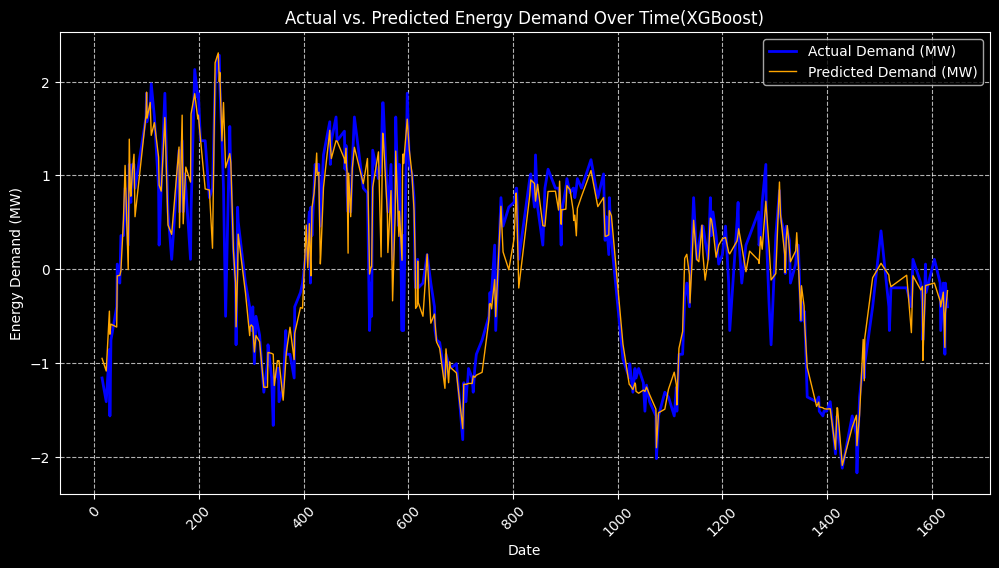

In [25]:

import matplotlib.pyplot as plt
import seaborn as sns
import os
os.makedirs("./generated", exist_ok=True)


# Sort values by date
df3_test = pd.DataFrame({'Date': X_test.index, 'Actual': y_test, 'Predicted': y_pred})
df3_test = df3_test.sort_values(by="Date")


plt.figure(figsize=(12, 6))
plt.style.use('dark_background')
sns.set_palette(palette='gnuplot2_r')
plt.plot(df3_test["Date"], df3_test["Actual"], label="Actual Demand (MW)", color='blue', linewidth=2)
plt.plot(df3_test["Date"], df3_test["Predicted"], label="Predicted Demand (MW)", color='orange', linestyle="-", linewidth=1)
plt.xlabel("Date")
plt.ylabel("Energy Demand (MW)")
plt.title("Actual vs. Predicted Energy Demand Over Time(XGBoost)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('./generated/1.png',dpi=500)
plt.show()
